🤖 CIC-IDS2017 Machine Learning Pipeline 
🚀 RUNNING COMPLETE ML PIPELINE 
 Data prepared:
   Training set: 70,000 samples
   Test set: 30,000 samples
   Features: 88
   Attack rate (train): 19.79%
   Attack rate (test): 19.79%
 Isolation Forest trained
One-Class SVM trained
✅ Elliptic Envelope trained
✅ Local Outlier Factor trained
✅ PCA-based detector trained (threshold: 0.0687)
   Components retained: 30
   Explained variance ratio: 0.9556
  Training random_forest...
    SMOTE applied: 112,294 samples
     random_forest trained
  Training logistic_regression...
    SMOTE applied: 112,294 samples
     logistic_regression trained
✅ Ensemble model created with weights: {'isolation_forest': 0.25, 'one_class_svm': 0.25, 'pca_detector': 0.25, 'random_forest': 0.25}

📊 EVALUATING MODELS

🔍 ISOLATION_FOREST EVALUATION:
  Accuracy: 0.8087
  Precision: 0.5197
  Recall: 0.4426
  F1-Score: 0.4781
  AUC Score: 0.2574

🔍 ONE_CLASS_SVM EVALUATION:
  Accuracy: 0.8163
  Precision: 0.5416
  Recall: 0.4

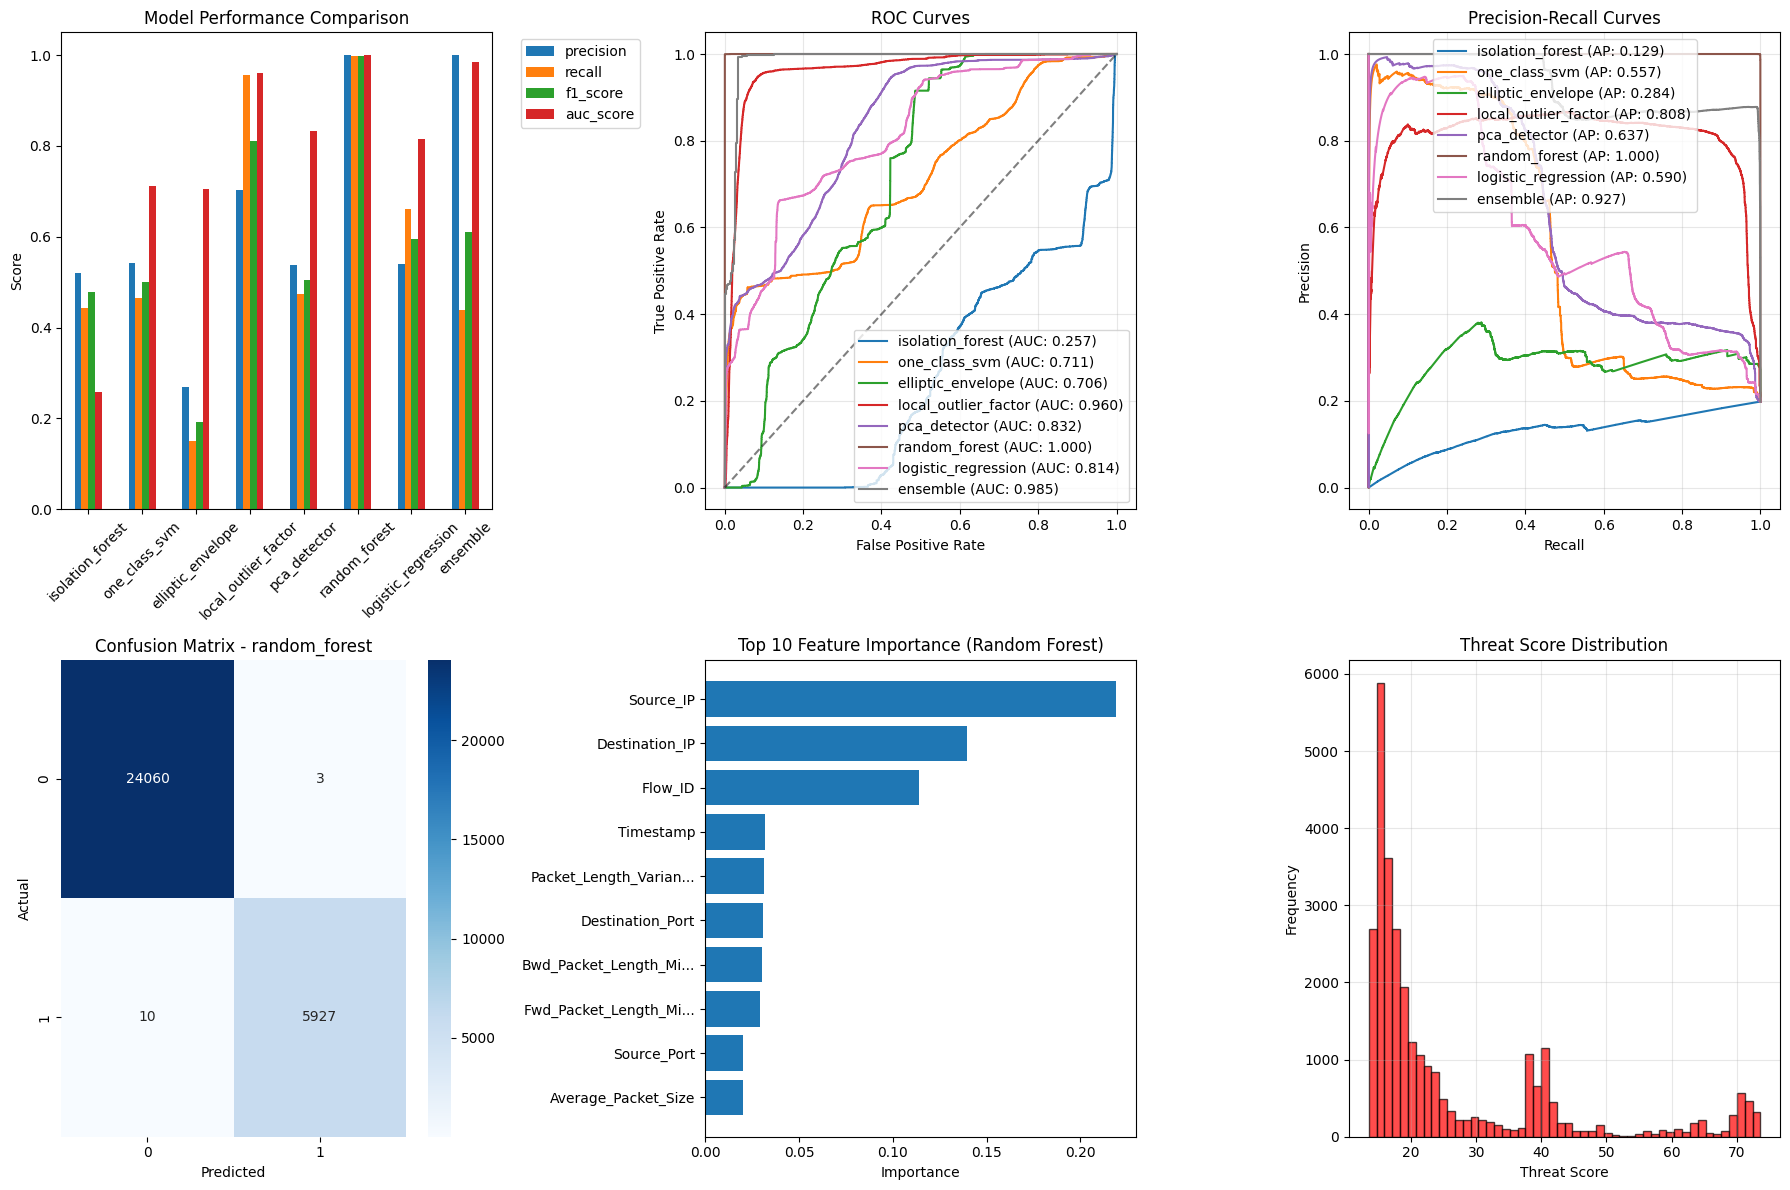

✅ Visualizations created!

💾 Saving models to models/...
  ✅ isolation_forest saved
  ✅ one_class_svm saved
  ✅ elliptic_envelope saved
  ✅ local_outlier_factor saved
  ✅ pca_detector saved
  ✅ random_forest saved
  ✅ logistic_regression saved
✅ Models saved successfully!

🎯 KEY OUTPUTS:
1. Trained models saved in 'models/' directory
2. Model comparison results in 'model_comparison.csv'
3. Threat scoring system ready for dashboard
4. Model performance visualizations generated
 'test_data_with_threats.csv' has been saved!


In [6]:
#Advanced Machine Learning Models 


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

class NetworkAnomalyDetector:
    """
    Comprehensive anomaly detection system for network traffic 
    """
    
    def __init__(self, df):
        self.df = df
        self.models = {}
        self.results = {}
        self.feature_columns = [col for col in df.columns if col not in ['Label', 'Is_Attack', 'Label_Encoded']]
        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        
    def prepare_data(self, test_size=0.3, random_state=42):
        """Prepare data for machine learning"""
        
        # Prepare features and target
        self.X = self.df[self.feature_columns]
        self.y = self.df['Is_Attack'] if 'Is_Attack' in self.df.columns else None
        
        if self.y is None:
            print("❌ No target variable found!")
            return False
        
        # Handle any remaining NaN or infinite values
        self.X = self.X.replace([np.inf, -np.inf], np.nan)
        self.X = self.X.fillna(self.X.median())
        
        # Train-test split with stratification
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state, 
            stratify=self.y
        )
        
        print(f" Data prepared:")
        print(f"   Training set: {self.X_train.shape[0]:,} samples")
        print(f"   Test set: {self.X_test.shape[0]:,} samples")
        print(f"   Features: {self.X_train.shape[1]}")
        print(f"   Attack rate (train): {self.y_train.mean()*100:.2f}%")
        print(f"   Attack rate (test): {self.y_test.mean()*100:.2f}%")
        
        return True
    
    def train_isolation_forest(self, contamination=0.1):
        """Train Isolation Forest for unsupervised anomaly detection"""
        
        # Train on normal data only (unsupervised approach)
        normal_data = self.X_train[self.y_train == 0]
        
        model = IsolationForest(
            contamination=contamination,
            random_state=42,
            n_estimators=100,
            max_samples='auto'
        )
        
        model.fit(normal_data)
        
        # Predictions
        train_pred = model.predict(self.X_train)
        test_pred = model.predict(self.X_test)
        
        # Convert to binary (1 for normal, -1 for anomaly -> 0 for normal, 1 for anomaly)
        train_pred_binary = (train_pred == -1).astype(int)
        test_pred_binary = (test_pred == -1).astype(int)
        
        # Calculate scores
        train_scores = model.decision_function(self.X_train)
        test_scores = model.decision_function(self.X_test)
        
        self.models['isolation_forest'] = model
        self.results['isolation_forest'] = {
            'train_predictions': train_pred_binary,
            'test_predictions': test_pred_binary,
            'train_scores': train_scores,
            'test_scores': test_scores,
            'model_type': 'unsupervised'
        }
        
        print(f" Isolation Forest trained")
        return model
    
    def train_one_class_svm(self, nu=0.1):
        """Train One-Class SVM for anomaly detection (replaces autoencoder)"""
        
        # Prepare data for One-Class SVM (train on normal data only)
        normal_data = self.X_train[self.y_train == 0]
        scaler = StandardScaler()
        normal_data_scaled = scaler.fit_transform(normal_data)
        
        # Build One-Class SVM
        model = OneClassSVM(
            nu=nu,  # Proportion of outliers expected
            kernel='rbf',
            gamma='scale'
        )
        
        # Train on normal data
        model.fit(normal_data_scaled)
        
        # Scale all data for predictions
        X_train_scaled = scaler.transform(self.X_train)
        X_test_scaled = scaler.transform(self.X_test)
        
        # Predictions
        train_pred = model.predict(X_train_scaled)
        test_pred = model.predict(X_test_scaled)
        
        # Convert to binary (1 for normal, -1 for anomaly -> 0 for normal, 1 for anomaly)
        train_pred_binary = (train_pred == -1).astype(int)
        test_pred_binary = (test_pred == -1).astype(int)
        
        # Calculate decision scores
        train_scores = model.decision_function(X_train_scaled)
        test_scores = model.decision_function(X_test_scaled)
        
        # Convert scores to anomaly scores (higher = more anomalous)
        train_anomaly_scores = -train_scores  # Flip sign
        test_anomaly_scores = -test_scores
        
        self.models['one_class_svm'] = {
            'model': model,
            'scaler': scaler
        }
        
        self.results['one_class_svm'] = {
            'train_predictions': train_pred_binary,
            'test_predictions': test_pred_binary,
            'train_scores': train_anomaly_scores,
            'test_scores': test_anomaly_scores,
            'model_type': 'unsupervised'
        }
        
        print(f"One-Class SVM trained")
        return model, scaler
    
    def train_elliptic_envelope(self, contamination=0.1):
        """Train Elliptic Envelope for anomaly detection"""
        
        # Prepare data (train on normal data only)
        normal_data = self.X_train[self.y_train == 0]
        scaler = RobustScaler()  # Use RobustScaler for better outlier handling
        normal_data_scaled = scaler.fit_transform(normal_data)
        
        # Build Elliptic Envelope
        model = EllipticEnvelope(
            contamination=contamination,
            random_state=42,
            support_fraction=None  # Auto-determine
        )
        
        # Train on normal data
        model.fit(normal_data_scaled)
        
        # Scale all data for predictions
        X_train_scaled = scaler.transform(self.X_train)
        X_test_scaled = scaler.transform(self.X_test)
        
        # Predictions
        train_pred = model.predict(X_train_scaled)
        test_pred = model.predict(X_test_scaled)
        
        # Convert to binary (1 for normal, -1 for anomaly -> 0 for normal, 1 for anomaly)
        train_pred_binary = (train_pred == -1).astype(int)
        test_pred_binary = (test_pred == -1).astype(int)
        
        # Calculate Mahalanobis distances as anomaly scores
        train_scores = model.mahalanobis(X_train_scaled)
        test_scores = model.mahalanobis(X_test_scaled)
        
        self.models['elliptic_envelope'] = {
            'model': model,
            'scaler': scaler
        }
        
        self.results['elliptic_envelope'] = {
            'train_predictions': train_pred_binary,
            'test_predictions': test_pred_binary,
            'train_scores': train_scores,
            'test_scores': test_scores,
            'model_type': 'unsupervised'
        }
        
        print(f"✅ Elliptic Envelope trained")
        return model, scaler
    
    def train_local_outlier_factor(self, contamination=0.1, n_neighbors=20):
        """Train Local Outlier Factor for anomaly detection"""
        
        # Prepare data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(self.X_train)
        X_test_scaled = scaler.transform(self.X_test)
        
        # Build LOF model
        model = LocalOutlierFactor(
            n_neighbors=n_neighbors,
            contamination=contamination,
            novelty=True  # For prediction on new data
        )
        
        # Train on normal data only
        normal_data = X_train_scaled[self.y_train == 0]
        model.fit(normal_data)
        
        # Predictions
        train_pred = model.predict(X_train_scaled)
        test_pred = model.predict(X_test_scaled)
        
        # Convert to binary (1 for normal, -1 for anomaly -> 0 for normal, 1 for anomaly)
        train_pred_binary = (train_pred == -1).astype(int)
        test_pred_binary = (test_pred == -1).astype(int)
        
        # Calculate anomaly scores
        train_scores = model.decision_function(X_train_scaled)
        test_scores = model.decision_function(X_test_scaled)
        
        # Convert to anomaly scores (higher = more anomalous)
        train_anomaly_scores = -train_scores
        test_anomaly_scores = -test_scores
        
        self.models['local_outlier_factor'] = {
            'model': model,
            'scaler': scaler
        }
        
        self.results['local_outlier_factor'] = {
            'train_predictions': train_pred_binary,
            'test_predictions': test_pred_binary,
            'train_scores': train_anomaly_scores,
            'test_scores': test_anomaly_scores,
            'model_type': 'unsupervised'
        }
        
        print(f"✅ Local Outlier Factor trained")
        return model, scaler
    
    def train_pca_based_detector(self, n_components=0.95, contamination=0.1):
        """Train PCA-based anomaly detector (alternative to autoencoder)"""
        
        # Prepare data (train on normal data only)
        normal_data = self.X_train[self.y_train == 0]
        scaler = StandardScaler()
        normal_data_scaled = scaler.fit_transform(normal_data)
        
        # Apply PCA for dimensionality reduction
        pca = PCA(n_components=n_components, random_state=42)
        normal_data_pca = pca.fit_transform(normal_data_scaled)
        
        # Reconstruct data
        normal_data_reconstructed = pca.inverse_transform(normal_data_pca)
        
        # Calculate reconstruction errors for normal data
        reconstruction_errors = np.mean(np.power(normal_data_scaled - normal_data_reconstructed, 2), axis=1)
        
        # Set threshold based on percentile of normal data reconstruction errors
        threshold = np.percentile(reconstruction_errors, (1 - contamination) * 100)
        
        # Apply to all data
        X_train_scaled = scaler.transform(self.X_train)
        X_test_scaled = scaler.transform(self.X_test)
        
        # Transform and reconstruct
        X_train_pca = pca.transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)
        
        X_train_reconstructed = pca.inverse_transform(X_train_pca)
        X_test_reconstructed = pca.inverse_transform(X_test_pca)
        
        # Calculate reconstruction errors
        train_errors = np.mean(np.power(X_train_scaled - X_train_reconstructed, 2), axis=1)
        test_errors = np.mean(np.power(X_test_scaled - X_test_reconstructed, 2), axis=1)
        
        # Make predictions
        train_pred_binary = (train_errors > threshold).astype(int)
        test_pred_binary = (test_errors > threshold).astype(int)
        
        self.models['pca_detector'] = {
            'pca': pca,
            'scaler': scaler,
            'threshold': threshold
        }
        
        self.results['pca_detector'] = {
            'train_predictions': train_pred_binary,
            'test_predictions': test_pred_binary,
            'train_scores': train_errors,
            'test_scores': test_errors,
            'model_type': 'unsupervised',
            'threshold': threshold
        }
        
        print(f"✅ PCA-based detector trained (threshold: {threshold:.4f})")
        print(f"   Components retained: {pca.n_components_}")
        print(f"   Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")
        
        return pca, scaler, threshold
    
    def train_supervised_models(self, use_smote=True):
        """Train supervised models with class balancing"""
        
        models_to_train = {
            'random_forest': RandomForestClassifier(
                n_estimators=100,
                max_depth=10,
                random_state=42,
                n_jobs=-1
            ),
            'logistic_regression': LogisticRegression(
                random_state=42,
                max_iter=1000
            )
        }
        
        for name, model in models_to_train.items():
            print(f"  Training {name}...")
            
            X_train_resampled = self.X_train
            y_train_resampled = self.y_train
            
            # Apply SMOTE if requested
            if use_smote:
                smote = SMOTE(random_state=42)
                X_train_resampled, y_train_resampled = smote.fit_resample(self.X_train, self.y_train)
                print(f"    SMOTE applied: {len(y_train_resampled):,} samples")
            
            # Train model
            model.fit(X_train_resampled, y_train_resampled)
            
            # Predictions
            train_pred = model.predict(self.X_train)
            test_pred = model.predict(self.X_test)
            
            # Prediction probabilities
            train_proba = model.predict_proba(self.X_train)[:, 1]
            test_proba = model.predict_proba(self.X_test)[:, 1]
            
            self.models[name] = model
            self.results[name] = {
                'train_predictions': train_pred,
                'test_predictions': test_pred,
                'train_probabilities': train_proba,
                'test_probabilities': test_proba,
                'model_type': 'supervised'
            }
            
            print(f"     {name} trained")
    
    def create_ensemble_model(self, weights=None):
        """Create ensemble model combining multiple approaches"""
        
        
        if weights is None:
            weights = {
                'isolation_forest': 0.25,
                'one_class_svm': 0.25,
                'pca_detector': 0.25,
                'random_forest': 0.25
            }
        
        # Normalize scores for ensemble
        ensemble_train_scores = np.zeros(len(self.X_train))
        ensemble_test_scores = np.zeros(len(self.X_test))
        
        total_weight = 0
        
        for model_name, weight in weights.items():
            if model_name in self.results:
                # Get scores (higher = more anomalous)
                if model_name in ['isolation_forest']:
                    # Convert isolation forest scores (lower = more anomalous)
                    train_scores = -self.results[model_name]['train_scores']
                    test_scores = -self.results[model_name]['test_scores']
                elif model_name in ['one_class_svm', 'local_outlier_factor', 'elliptic_envelope', 'pca_detector']:
                    train_scores = self.results[model_name]['train_scores']
                    test_scores = self.results[model_name]['test_scores']
                elif model_name in ['random_forest', 'logistic_regression']:
                    train_scores = self.results[model_name]['train_probabilities']
                    test_scores = self.results[model_name]['test_probabilities']
                else:
                    continue
                
                # Normalize scores to [0, 1]
                train_scores_norm = (train_scores - train_scores.min()) / (train_scores.max() - train_scores.min() + 1e-10)
                test_scores_norm = (test_scores - test_scores.min()) / (test_scores.max() - test_scores.min() + 1e-10)
                
                # Add weighted scores
                ensemble_train_scores += weight * train_scores_norm
                ensemble_test_scores += weight * test_scores_norm
                total_weight += weight
        
        # Normalize by total weight
        if total_weight > 0:
            ensemble_train_scores /= total_weight
            ensemble_test_scores /= total_weight
        
        # Create ensemble predictions using threshold
        ensemble_threshold = 0.5
        ensemble_train_pred = (ensemble_train_scores > ensemble_threshold).astype(int)
        ensemble_test_pred = (ensemble_test_scores > ensemble_threshold).astype(int)
        
        self.results['ensemble'] = {
            'train_predictions': ensemble_train_pred,
            'test_predictions': ensemble_test_pred,
            'train_scores': ensemble_train_scores,
            'test_scores': ensemble_test_scores,
            'model_type': 'ensemble',
            'weights': weights,
            'threshold': ensemble_threshold
        }
        
        print(f"✅ Ensemble model created with weights: {weights}")
        return ensemble_train_scores, ensemble_test_scores
    
    def evaluate_models(self):
        """Comprehensive evaluation of all models"""
        print(f"\n📊 EVALUATING MODELS")
        print("=" * 50)
        
        evaluation_results = {}
        
        for model_name, results in self.results.items():
            print(f"\n🔍 {model_name.upper()} EVALUATION:")
            
            test_pred = results['test_predictions']
            
            # Classification report
            report = classification_report(self.y_test, test_pred, output_dict=True)
            
            # Additional metrics
            try:
                if 'test_probabilities' in results:
                    auc_score = roc_auc_score(self.y_test, results['test_probabilities'])
                elif 'test_scores' in results:
                    auc_score = roc_auc_score(self.y_test, results['test_scores'])
                else:
                    auc_score = 0.5
            except:
                auc_score = 0.5
            
            # Store evaluation metrics
            evaluation_results[model_name] = {
                'accuracy': report['accuracy'],
                'precision': report['1']['precision'],
                'recall': report['1']['recall'],
                'f1_score': report['1']['f1-score'],
                'auc_score': auc_score,
                'support': report['1']['support']
            }
            
            print(f"  Accuracy: {report['accuracy']:.4f}")
            print(f"  Precision: {report['1']['precision']:.4f}")
            print(f"  Recall: {report['1']['recall']:.4f}")
            print(f"  F1-Score: {report['1']['f1-score']:.4f}")
            print(f"  AUC Score: {auc_score:.4f}")
        
        # Create comparison DataFrame
        comparison_df = pd.DataFrame(evaluation_results).T
        comparison_df = comparison_df.round(4)
        
        print(f"\n📈 MODEL COMPARISON:")
        print(comparison_df)
        
        # Find best model
        best_model = comparison_df['f1_score'].idxmax()
        print(f"\n🏆 Best Model: {best_model} (F1-Score: {comparison_df.loc[best_model, 'f1_score']:.4f})")
        
        return comparison_df
    
    def create_threat_score(self):
        """Create custom threat scoring system"""
        
        
        # Use ensemble scores as base
        if 'ensemble' in self.results:
            base_scores = self.results['ensemble']['test_scores']
        elif 'random_forest' in self.results:
            base_scores = self.results['random_forest']['test_probabilities']
        else:
            print("❌ No suitable model for threat scoring!")
            return None
        
        # Create threat score components
        threat_scores = pd.DataFrame({
            'Base_Anomaly_Score': base_scores,
            'Confidence_Level': base_scores,  # Use anomaly score as confidence
        })
        
        # Add protocol severity (if available)
        # This is a placeholder - customize based on your protocol analysis
        threat_scores['Protocol_Weight'] = 1.0  # Default weight
        
        # Calculate final threat score (0-100 scale)
        threat_scores['Threat_Score'] = (
            0.7 * threat_scores['Base_Anomaly_Score'] * 100 +
            0.2 * threat_scores['Confidence_Level'] * 100 +
            0.1 * threat_scores['Protocol_Weight'] * 100
        ).clip(0, 100)
        
        # Categorize threat levels
        threat_scores['Threat_Level'] = pd.cut(
            threat_scores['Threat_Score'],
            bins=[0, 25, 50, 75, 100],
            labels=['Low', 'Medium', 'High', 'Critical']
        )
        
        # Add to test data
        test_data_with_threats = self.X_test.copy()
        test_data_with_threats['Threat_Score'] = threat_scores['Threat_Score']
        test_data_with_threats['Threat_Level'] = threat_scores['Threat_Level']
        test_data_with_threats['Actual_Attack'] = self.y_test
        
        print(f"✅ Threat scoring complete!")
        print(f"Threat Level Distribution:")
        print(threat_scores['Threat_Level'].value_counts())
        
        return test_data_with_threats, threat_scores
    
    def visualize_results(self):
        """Create comprehensive visualizations"""
        
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # 1. Model Comparison
        if hasattr(self, 'comparison_df'):
            metrics = ['precision', 'recall', 'f1_score', 'auc_score']
            comparison_data = self.comparison_df[metrics]
            
            comparison_data.plot(kind='bar', ax=axes[0, 0])
            axes[0, 0].set_title('Model Performance Comparison')
            axes[0, 0].set_ylabel('Score')
            axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            axes[0, 0].tick_params(axis='x', rotation=45)
        
        # 2. ROC Curves
        axes[0, 1].set_title('ROC Curves')
        for model_name, results in self.results.items():
            try:
                if 'test_probabilities' in results:
                    scores = results['test_probabilities']
                elif 'test_scores' in results:
                    scores = results['test_scores']
                else:
                    continue
                
                fpr, tpr, _ = roc_curve(self.y_test, scores)
                auc = roc_auc_score(self.y_test, scores)
                axes[0, 1].plot(fpr, tpr, label=f'{model_name} (AUC: {auc:.3f})')
            except:
                continue
        
        axes[0, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
        axes[0, 1].set_xlabel('False Positive Rate')
        axes[0, 1].set_ylabel('True Positive Rate')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Precision-Recall Curves
        axes[0, 2].set_title('Precision-Recall Curves')
        for model_name, results in self.results.items():
            try:
                if 'test_probabilities' in results:
                    scores = results['test_probabilities']
                elif 'test_scores' in results:
                    scores = results['test_scores']
                else:
                    continue
                
                precision, recall, _ = precision_recall_curve(self.y_test, scores)
                avg_precision = average_precision_score(self.y_test, scores)
                axes[0, 2].plot(recall, precision, label=f'{model_name} (AP: {avg_precision:.3f})')
            except:
                continue
        
        axes[0, 2].set_xlabel('Recall')
        axes[0, 2].set_ylabel('Precision')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
        
        # 4. Confusion Matrix (Best Model)
        if hasattr(self, 'comparison_df'):
            best_model = self.comparison_df['f1_score'].idxmax()
            best_predictions = self.results[best_model]['test_predictions']
            
            cm = confusion_matrix(self.y_test, best_predictions)
            sns.heatmap(cm, annot=True, fmt='d', ax=axes[1, 0], cmap='Blues')
            axes[1, 0].set_title(f'Confusion Matrix - {best_model}')
            axes[1, 0].set_xlabel('Predicted')
            axes[1, 0].set_ylabel('Actual')
        
        # 5. Feature Importance (if Random Forest available)
        if 'random_forest' in self.models:
            rf_model = self.models['random_forest']
            feature_importance = pd.DataFrame({
                'feature': self.feature_columns,
                'importance': rf_model.feature_importances_
            }).sort_values('importance', ascending=False).head(10)
            
            axes[1, 1].barh(range(len(feature_importance)), feature_importance['importance'])
            axes[1, 1].set_yticks(range(len(feature_importance)))
            axes[1, 1].set_yticklabels([f[:20] + '...' if len(f) > 20 else f 
                                       for f in feature_importance['feature']])
            axes[1, 1].set_xlabel('Importance')
            axes[1, 1].set_title('Top 10 Feature Importance (Random Forest)')
            axes[1, 1].invert_yaxis()
        
        # 6. Threat Score Distribution
        if hasattr(self, 'threat_scores'):
            axes[1, 2].hist(self.threat_scores['Threat_Score'], bins=50, alpha=0.7, color='red', edgecolor='black')
            axes[1, 2].set_xlabel('Threat Score')
            axes[1, 2].set_ylabel('Frequency')
            axes[1, 2].set_title('Threat Score Distribution')
            axes[1, 2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("✅ Visualizations created!")
    
    def save_models(self, save_path="models/"):
        """Save trained models"""
        import os
        os.makedirs(save_path, exist_ok=True)
        
        print(f"\n💾 Saving models to {save_path}...")
        
        for model_name, model in self.models.items():
            try:
                # Save all models using joblib
                joblib.dump(model, f"{save_path}{model_name}.pkl")
                print(f"  ✅ {model_name} saved")
            except Exception as e:
                print(f"  ❌ Failed to save {model_name}: {e}")
        
        # Save results and evaluation
        joblib.dump(self.results, f"{save_path}model_results.pkl")
        if hasattr(self, 'comparison_df'):
            self.comparison_df.to_csv(f"{save_path}model_comparison.csv")
        
        print("✅ Models saved successfully!")
    
    def run_complete_pipeline(self, use_smote=True, save_models=True):
        """Run the complete ML pipeline"""
        print("🚀 RUNNING COMPLETE ML PIPELINE ")
        print("=" * 60)
        
        # Step 1: Prepare data
        if not self.prepare_data():
            return False
        
        # Step 2: Train unsupervised models (replacing autoencoder with multiple alternatives)
        self.train_isolation_forest()
        self.train_one_class_svm()
        self.train_elliptic_envelope()
        self.train_local_outlier_factor()
        self.train_pca_based_detector()
        
        # Step 3: Train supervised models
        self.train_supervised_models(use_smote=use_smote)
        
        # Step 4: Create ensemble
        self.create_ensemble_model()
        
        # Step 5: Evaluate models
        self.comparison_df = self.evaluate_models()
        
        # Step 6: Create threat scoring
        self.test_data_with_threats, self.threat_scores = self.create_threat_score()
        
        # Step 7: Visualize results
        self.visualize_results()
        
        # Step 8: Save models
        if save_models:
            self.save_models()
        
        
        
        return True

def main():
    """Main function to run ML pipeline"""
    print("🤖 CIC-IDS2017 Machine Learning Pipeline ")
    print("=" * 60)
    
    # Uncomment when you have processed data
    df = pd.read_csv('processed_network_data.csv')
    
    # Initialize ML system
    ml_system = NetworkAnomalyDetector(df)
    
    # Run complete pipeline
    success = ml_system.run_complete_pipeline(
        use_smote=True,
        save_models=True
    )
    
    if success:
        print("\n🎯 KEY OUTPUTS:")
        print("1. Trained models saved in 'models/' directory")
        print("2. Model comparison results in 'model_comparison.csv'")
        print("3. Threat scoring system ready for dashboard")
        print("4. Model performance visualizations generated")
        
        ml_system.test_data_with_threats.to_csv('test_data_with_threats.csv', index=False)
        print(" 'test_data_with_threats.csv' has been saved!")
       

# Additional utility functions for enhanced functionality
def compare_models_detailed(results_dict, y_true):
    """
    Detailed comparison of model performance
    """
    print("\n📈 DETAILED MODEL COMPARISON")
    print("=" * 50)
    
    detailed_metrics = {}
    
    for model_name, results in results_dict.items():
        predictions = results['test_predictions']
        
        # Calculate detailed metrics
        tn, fp, fn, tp = confusion_matrix(y_true, predictions).ravel()
        
        detailed_metrics[model_name] = {
            'True Positives': tp,
            'True Negatives': tn,
            'False Positives': fp,
            'False Negatives': fn,
            'Precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
            'Recall': tp / (tp + fn) if (tp + fn) > 0 else 0,
            'Specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
            'False Positive Rate': fp / (fp + tn) if (fp + tn) > 0 else 0,
            'Accuracy': (tp + tn) / (tp + tn + fp + fn)
        }
    
    # Convert to DataFrame for better visualization
    detailed_df = pd.DataFrame(detailed_metrics).T
    print(detailed_df.round(4))
    
    return detailed_df

def create_model_ensemble_weights_optimizer(detector, validation_split=0.2):
    """
    Optimize ensemble weights using validation data
    """
    print("\n🎯 Optimizing Ensemble Weights...")
    
    # Split training data for validation
    X_train_sub, X_val, y_train_sub, y_val = train_test_split(
        detector.X_train, detector.y_train, 
        test_size=validation_split, 
        random_state=42, 
        stratify=detector.y_train
    )
    
    # Get predictions on validation set for each model
    val_scores = {}
    
    for model_name, model_info in detector.models.items():
        if model_name == 'one_class_svm':
            scaler = model_info['scaler']
            model = model_info['model']
            X_val_scaled = scaler.transform(X_val)
            scores = -model.decision_function(X_val_scaled)  # Higher = more anomalous
            
        elif model_name == 'elliptic_envelope':
            scaler = model_info['scaler']
            model = model_info['model']
            X_val_scaled = scaler.transform(X_val)
            scores = model.mahalanobis(X_val_scaled)
            
        elif model_name == 'local_outlier_factor':
            scaler = model_info['scaler']
            model = model_info['model']
            X_val_scaled = scaler.transform(X_val)
            scores = -model.decision_function(X_val_scaled)
            
        elif model_name == 'pca_detector':
            scaler = model_info['scaler']
            pca = model_info['pca']
            X_val_scaled = scaler.transform(X_val)
            X_val_pca = pca.transform(X_val_scaled)
            X_val_reconstructed = pca.inverse_transform(X_val_pca)
            scores = np.mean(np.power(X_val_scaled - X_val_reconstructed, 2), axis=1)
            
        elif model_name == 'isolation_forest':
            scores = -model_info.decision_function(X_val)
            
        elif model_name in ['random_forest', 'logistic_regression']:
            scores = model_info.predict_proba(X_val)[:, 1]
            
        else:
            continue
            
        # Normalize scores
        val_scores[model_name] = (scores - scores.min()) / (scores.max() - scores.min() + 1e-10)
    
    # Simple grid search for optimal weights
    from itertools import product
    
    best_f1 = 0
    best_weights = {}
    
    # Define weight ranges (simplified for computational efficiency)
    weight_options = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    
    print("   Searching for optimal weights...")
    
    # Try different weight combinations (simplified approach)
    model_names = list(val_scores.keys())
    
    for weights in product(weight_options, repeat=len(model_names)):
        if sum(weights) == 0:
            continue
            
        # Normalize weights
        weights = np.array(weights)
        weights = weights / weights.sum()
        
        # Calculate ensemble score
        ensemble_score = np.zeros(len(y_val))
        for i, model_name in enumerate(model_names):
            ensemble_score += weights[i] * val_scores[model_name]
        
        # Make predictions using threshold
        predictions = (ensemble_score > 0.5).astype(int)
        
        # Calculate F1 score
        try:
            from sklearn.metrics import f1_score
            f1 = f1_score(y_val, predictions)
            
            if f1 > best_f1:
                best_f1 = f1
                best_weights = dict(zip(model_names, weights))
        except:
            continue
    
    print(f"   ✅ Optimal weights found (F1: {best_f1:.4f}):")
    for model, weight in best_weights.items():
        print(f"      {model}: {weight:.3f}")
    
    return best_weights

def generate_anomaly_report(detector, top_n=10):
    """
    Generate detailed anomaly report
    """
    print(f"\n📋 GENERATING ANOMALY REPORT (Top {top_n})")
    print("=" * 50)
    
    if not hasattr(detector, 'test_data_with_threats'):
        print("❌ Threat scoring not available!")
        return None
    
    # Get top anomalies
    top_anomalies = detector.test_data_with_threats.nlargest(top_n, 'Threat_Score')
    
    print(f"🚨 TOP {top_n} ANOMALIES DETECTED:")
    print("-" * 40)
    
    for idx, (_, row) in enumerate(top_anomalies.iterrows(), 1):
        print(f"\n{idx}. Anomaly ID: {row.name}")
        print(f"   Threat Score: {row['Threat_Score']:.2f}")
        print(f"   Threat Level: {row['Threat_Level']}")
        print(f"   Actual Attack: {'Yes' if row['Actual_Attack'] else 'No'}")
        
        # Show top features (if Random Forest available)
        if 'random_forest' in detector.models:
            rf_model = detector.models['random_forest']
            feature_values = row[detector.feature_columns]
            
            # Get feature importance and multiply by values for this sample
            importances = rf_model.feature_importances_
            weighted_features = feature_values * importances
            top_features = weighted_features.nlargest(3)
            
            print(f"   Key Features:")
            for feature, value in top_features.items():
                print(f"     - {feature}: {value:.4f}")
    
    # Summary statistics
    print(f"\n📊 ANOMALY SUMMARY:")
    print(f"   Total samples analyzed: {len(detector.test_data_with_threats):,}")
    print(f"   High/Critical threats: {len(detector.test_data_with_threats[detector.test_data_with_threats['Threat_Level'].isin(['High', 'Critical'])]):,}")
    print(f"   Actual attacks detected: {detector.test_data_with_threats['Actual_Attack'].sum():,}")
    
    return top_anomalies

if __name__ == "__main__":
    main()